
#Отчет о проделанной работе


#Постановка задачи

Задача: бинарная классификация изображений

Классы: есть солнцезащитные очки, нет солнцезащитных очков

Формат изображений: 30х32, grayscale, jpg. Примеры изображений:

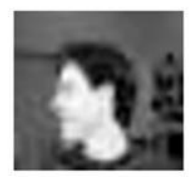
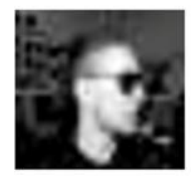

Предлагаемая схема решения:
- 2D сверточная НС: выход – 1 нейрон (сигмоида)
- Функция потерь: кросс энтропия (binary cross entropy)

Размеры выборок:
- Обучающая: 378 изображений
- Тестовая: 22140 изображений.

Возможная проблема: переобучение.

Способы решения:
- упрощение архитектуры нейронной сети;
- выбор момента остановки обучения;
- увеличение обучающей выборки за счет преобразования исходных
изображений;
- обучение нескольких сетей и усреднение их предсказаний.
 аугментация изображений:
 шум, аффинные преобразования
- регуляризация
- dropout
- кросс-валидация

Метрика качества:

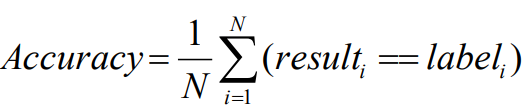

#Распаковка архивов, добавление библиотек

#Загрузка изображений и нормализация

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizerst
import zipfile
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from keras.regularizers import l2
from sklearn.model_selection import train_test_split


# Распаковка тестовой выборки
with zipfile.ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall('test')

# Загрузка CSV с метками
labels = pd.read_csv('train_tags.csv')

# Преобразование меток в бинарный формат: 1 - "sunglasses", 0 - "open"
labels['tag'] = labels['tag'].map({'sunglasses': 1, 'open': 0})

input_shape = (30, 32, 1)
batch_size = 32
epochs = 30
val_split = 0.2


In [ ]:
from PIL import Image

def load_images_with_labels(folder_path, labels_csv=None, input_shape=(30, 32, 1), is_test=False):
    image_list = []
    label_list = []

    # Загрузка меток из CSV
    labels_dict = {}
    if labels_csv:
        df = pd.read_csv(labels_csv)
        labels_dict = dict(zip(df['id'], df['tag']))  # Используем 'id' и 'tag' для соответствия

    # Сортируем файлы по числовому значению имени (например, 1.jpg, 2.jpg, ...)
    files = sorted(
        [f for f in os.listdir(folder_path) if f.endswith(".jpg")],
        key=lambda x: int(os.path.splitext(x)[0])  # предполагаем, что имя файла - это число
    )

    # Вывод списка файлов и соответствующих меток
    print(f"Найдено {len(files)} изображений в папке '{folder_path}'.")

    for filename in files:
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)

        # Преобразуем в серые оттенки, если изображение цветное
        img = img.convert('L')
        img = img.resize((input_shape[1], input_shape[0]))  # Преобразуем изображение в нужный размер
        img = np.expand_dims(img, axis=-1)
        img = np.array(img)  # Преобразуем в массив NumPy
        img = img / 255.0  # Нормализуем пиксели от 0 до 1
        image_list.append(img)


        if not is_test:
            # Получаем метку по имени файла, если это не тестовые данные
            label = labels_dict.get(int(os.path.splitext(filename)[0]), None)  # Преобразуем имя в id
            label_list.append(label)
            # Выводим информацию о считываемом изображении и метке
            print(f"Файл: {filename} - Метка: {label}")
        else:
            label_list.append(None)  # Для тестовых данных метки не нужны

    # Возвращаем массивы изображений и меток (для теста метки будут None)
    return np.array(image_list), np.array(label_list)

# Пути к данным
train_folder_path = 'train'
train_labels_path = 'train_tags.csv'  # Путь к файлу с метками

X_train, y_train = load_images_with_labels(train_folder_path, train_labels_path)

if len(X_train) == 0:
    raise ValueError("Ошибка: обучающие изображения не загружены! Проверьте путь к папке 'train'.")

# Убедимся, что данные правильной формы
print(f"Успешно загружено обучающих изображений: {X_train.shape}")
test_folder_path = '/content/test/test'
X_test, _ = load_images_with_labels(test_folder_path, is_test=True)

if len(X_test) == 0:
    raise ValueError("Ошибка: тестовые изображения не загружены! Проверьте путь к папке 'test'.")

print(f"Успешно загружено тестовых изображений: {X_test.shape[0]}")


Найдено 378 изображений в папке 'train'.
Файл: 0.jpg - Метка: sunglasses
Файл: 1.jpg - Метка: open
Файл: 2.jpg - Метка: sunglasses
Файл: 3.jpg - Метка: sunglasses
Файл: 4.jpg - Метка: sunglasses
Файл: 5.jpg - Метка: sunglasses
Файл: 6.jpg - Метка: open
Файл: 7.jpg - Метка: sunglasses
Файл: 8.jpg - Метка: open
Файл: 9.jpg - Метка: open
Файл: 10.jpg - Метка: open
Файл: 11.jpg - Метка: open
Файл: 12.jpg - Метка: sunglasses
Файл: 13.jpg - Метка: sunglasses
Файл: 14.jpg - Метка: sunglasses
Файл: 15.jpg - Метка: sunglasses
Файл: 16.jpg - Метка: sunglasses
Файл: 17.jpg - Метка: sunglasses
Файл: 18.jpg - Метка: open
Файл: 19.jpg - Метка: open
Файл: 20.jpg - Метка: open
Файл: 21.jpg - Метка: sunglasses
Файл: 22.jpg - Метка: open
Файл: 23.jpg - Метка: open
Файл: 24.jpg - Метка: open
Файл: 25.jpg - Метка: sunglasses
Файл: 26.jpg - Метка: open
Файл: 27.jpg - Метка: open
Файл: 28.jpg - Метка: open
Файл: 29.jpg - Метка: open
Файл: 30.jpg - Метка: sunglasses
Файл: 31.jpg - Метка: sunglasses
Файл: 32.

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=val_split,  # Use your predefined val_split (0.2)
    random_state=42,
    stratify=y_train  # Preserve class distribution
)

# Загрузка CSV с метками и вывод столбцов
labels = pd.read_csv('train_tags.csv')
print(labels.columns)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
le = LabelEncoder()

# Объединяем
y_combined = np.concatenate([y_train, y_val])

# Кодируем
le = LabelEncoder()
y_combined_encoded = le.fit_transform(y_combined)

# Разделяем обратно
y_train = y_combined_encoded[:len(y_train)]
y_val = y_combined_encoded[len(y_train):]



Index(['id', 'tag'], dtype='object')


#Подбор структуры сети

**Базовая архитектура** - 2 слоя

Conv2D(32) → MaxPool → Conv2D(64) → MaxPool → Dense(64) → Sigmoid

неплохо обобщает, но склонна к переобучению на малой выборке



In [ ]:

def build_model_v1():
  model = Sequential([
      Conv2D(32, (3, 3), activation='relu', input_shape=(30, 32, 1)),
      MaxPooling2D((2, 2)),
      Conv2D(64, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Flatten(),
      Dense(64, activation='relu'),
      Dense(1, activation='sigmoid')
  ])
  return model
def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\n=== Обучение {model_name} ===")

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=1
    )

    val_pred = (model.predict(X_val) > 0.5).astype(int)
    print(f"\nРезультаты {model_name}:")
    print(classification_report(y_val, val_pred))

    return model, history
models = {
    'Base CNN (V1)': build_model_v1()
}

results = {}
for name, model in models.items():
    trained_model, history = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, name)
    results[name] = {
        'model': trained_model,
        'history': history,
        'params': model.count_params()
    }


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Обучение Base CNN (V1) ===
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.5490 - loss: 0.6896 - val_accuracy: 0.5000 - val_loss: 0.6953 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5107 - loss: 0.6907 - val_accuracy: 0.7632 - val_loss: 0.6746 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6993 - loss: 0.6670 - val_accuracy: 0.7895 - val_loss: 0.6389 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7083 - loss: 0.6157 - val_accuracy: 0.6711 - val_loss: 0.6053 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7328 - loss: 0.5592 - val_accuracy: 0.6579 - val_loss: 0.6004 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7403 - loss: 0.5423 - val_accuracy: 0.7105 - val_loss: 0.5061 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy

Результаты:

Val Accuracy: 0.9868, F1-score: 0.99.

Быстро достигла высокой точности (~20 эпох).

Проблемы:

Подозрительно высокая точность на валидации, возможное переобучение из-за малого размера данных.

---

**Глубокая архитектура (3 слоя)**

Conv2D(32) → MP → Conv2D(64) → MP → Conv2D(128) → MP → Dense(128) → Sigmoid

Более сбалансированная, чуть медленнее в обучении


In [ ]:
def build_model_v2():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(30,32,1)),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\n=== Обучение {model_name} ===")

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=1
    )

    val_pred = (model.predict(X_val) > 0.5).astype(int)
    print(f"\nРезультаты {model_name}:")
    print(classification_report(y_val, val_pred))

    return model, history
models = {
    'Deep CNN (V2)': build_model_v2()
}

results = {}
for name, model in models.items():
    trained_model, history = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, name)
    results[name] = {
        'model': trained_model,
        'history': history,
        'params': model.count_params()
    }


=== Обучение Deep CNN (V2) ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.5474 - loss: 0.6926 - val_accuracy: 0.5000 - val_loss: 0.6801 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5586 - loss: 0.6683 - val_accuracy: 0.6447 - val_loss: 0.6222 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7457 - loss: 0.5693 - val_accuracy: 0.7500 - val_loss: 0.5138 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7797 - loss: 0.4754 - val_accuracy: 0.6974 - val_loss: 0.5410 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8111 - loss: 0.3944 - val_accuracy: 0.8026 - val_loss: 0.3854 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8537 - loss: 0.3433 - val_accuracy: 0.8289 - val_loss: 0.3439 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8800 - loss: 0.2561 - val_accuracy: 0.89

Результаты:

Val Accuracy: 1.0000, F1-score: 0.99.

Еще более быстрое обучение.

Проблемы:

Явное переобучение (точность 100% на валидации).

Слишком сложная модель для маленького датасета.

---

**Широкая архитектура (больше фильтров)**

Conv2D(64) → MaxPool → Conv2D(128) → MaxPool → Conv2D(256) → GAP → Sigmoid





In [ ]:
def build_model_v3():
    model = Sequential([
        Conv2D(64, (3,3), activation='relu', input_shape=(30,32,1)),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Conv2D(256, (3,3), activation='relu'),
        GlobalAveragePooling2D(),

        Dense(1, activation='sigmoid')
    ])
    return model

def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\n=== Обучение {model_name} ===")

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=1
    )

    val_pred = (model.predict(X_val) > 0.5).astype(int)
    print(f"\nРезультаты {model_name}:")
    print(classification_report(y_val, val_pred))

    return model, history
models = {
    'Wide CNN (V3)': build_model_v3()
}

results = {}
for name, model in models.items():
    trained_model, history = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, name)
    results[name] = {
        'model': trained_model,
        'history': history,
        'params': model.count_params()
    }


=== Обучение Wide CNN (V3) ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 348ms/step - accuracy: 0.5122 - loss: 0.7271 - val_accuracy: 0.5000 - val_loss: 0.6925 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.4955 - loss: 0.6913 - val_accuracy: 0.5000 - val_loss: 0.6895 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.5054 - loss: 0.6907 - val_accuracy: 0.5000 - val_loss: 0.6842 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.5465 - loss: 0.6755 - val_accuracy: 0.5132 - val_loss: 0.6731 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.5460 - loss: 0.6606 - val_accuracy: 0.6316 - val_loss: 0.6300 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.6292 - loss: 0.6147 - val_accuracy: 0.6184 - val_loss: 0.5776 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.7288 - loss: 0.5459 - val_accurac

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

Результаты Wide CNN (V3):
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      0.97      0.99        38

    accuracy                           0.99        76
   macro avg       0.99      0.99      0.99        76
weighted avg       0.99      0.99      0.99        76



езультаты:

Val Accuracy: 0.9737, F1-score: 0.99.

Проблемы:

Медленное обучение, но стабильные результаты.

Большое количество параметров (369K).

---

**Сжатая архитектура**

Conv2D(16) → MaxPool → Conv2D(32) → MaxPool → Dense(32) → Sigmoid


In [ ]:
def build_model_v4():
    model = Sequential([
        Conv2D(16, (3,3), activation='relu', input_shape=(30,32,1)),
        MaxPooling2D((2,2)),

        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\n=== Обучение {model_name} ===")

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=1
    )

    val_pred = (model.predict(X_val) > 0.5).astype(int)
    print(f"\nРезультаты {model_name}:")
    print(classification_report(y_val, val_pred))

    return model, history
models = {
    'Compact CNN (V4)': build_model_v4()
}

results = {}
for name, model in models.items():
    trained_model, history = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, name)
    results[name] = {
        'model': trained_model,
        'history': history,
        'params': model.count_params()
    }

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Обучение Compact CNN (V4) ===
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.3765 - loss: 0.7134 - val_accuracy: 0.5132 - val_loss: 0.6879 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5572 - loss: 0.6779 - val_accuracy: 0.6974 - val_loss: 0.6709 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7796 - loss: 0.6536 - val_accuracy: 0.7632 - val_loss: 0.6408 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8012 - loss: 0.6125 - val_accuracy: 0.7632 - val_loss: 0.5997 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7798 - loss: 0.5489 - val_accuracy: 0.6711 - val_loss: 0.6106 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7769 - loss: 0.5273 - val_accuracy: 0.7500 - val_loss: 0.5087 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accura

Результаты:

Val Accuracy: 0.9868, F1-score: 0.99.

Плюсы:

Мало параметров (41K), но хорошая точность.

Менее склонна к переобучению.

---

**Гибридная архитектура**

Conv2D(48) → MP → Conv2D(96) → MP → Conv2D(192) → GAP → Dense(96) → Sigmoid

Требует много затрат

In [ ]:
def build_model_v5():
    model = Sequential([
        Conv2D(48, (3,3), activation='relu', input_shape=(30,32,1)),
        MaxPooling2D((2,2)),

        Conv2D(96, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Conv2D(192, (3,3), activation='relu'),
        GlobalAveragePooling2D(),

        Dense(96, activation='relu'),

        Dense(1, activation='sigmoid')
    ])
    return model


def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\n=== Обучение {model_name} ===")

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=1
    )

    val_pred = (model.predict(X_val) > 0.5).astype(int)
    print(f"\nРезультаты {model_name}:")
    print(classification_report(y_val, val_pred))

    return model, history
models = {
    'Hybrid CNN (V5)': build_model_v5()
}

results = {}
for name, model in models.items():
    trained_model, history = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, name)
    results[name] = {
        'model': trained_model,
        'history': history,
        'params': model.count_params()
    }



=== Обучение Hybrid CNN (V5) ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.4535 - loss: 0.6962 - val_accuracy: 0.5000 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5592 - loss: 0.6918 - val_accuracy: 0.5000 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5123 - loss: 0.6914 - val_accuracy: 0.5789 - val_loss: 0.6843 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5246 - loss: 0.6835 - val_accuracy: 0.6711 - val_loss: 0.6590 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6583 - loss: 0.6437 - val_accuracy: 0.5526 - val_loss: 0.6397 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6702 - loss: 0.6099 - val_accuracy: 0.7368 - val_loss: 0.5255 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.7615 - loss: 0.5234 - val_accuracy: 0.

Результаты:

Val Accuracy: 0.9868, F1-score: 0.97.

Проблемы:

Избыточная сложность для датасета.

----

##Анализ полученных результатов

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Обучение Base CNN (V1) ===
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5259 - loss: 0.6952 - val_accuracy: 0.6447 - val_loss: 0.6795 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6346 - loss: 0.6668 - val_accuracy: 0.6579 - val_loss: 0.6518 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7187 - loss: 0.6302 - val_accuracy: 0.5526 - val_loss: 0.6480 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6078 - loss: 0.5990 - val_accuracy: 0.5658 - val_loss: 0.6449 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6540 - loss: 0.5575 - val_accuracy: 0.7763 - val_loss: 0.5005 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7842 - loss: 0.4461 - val_accuracy: 0.7895 - val_loss: 0.4366 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy:

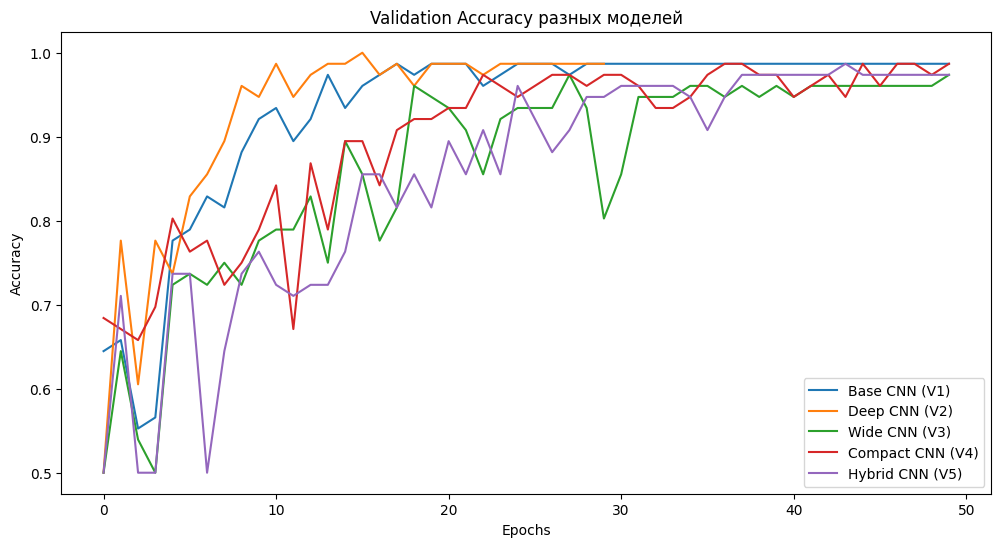

In [ ]:

models = {
    'Base CNN (V1)': build_model_v1(),
    'Deep CNN (V2)': build_model_v2(),
    'Wide CNN (V3)': build_model_v3(),
    'Compact CNN (V4)': build_model_v4(),
    'Hybrid CNN (V5)': build_model_v5()
}

results = {}
for name, model in models.items():
    trained_model, history = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, name)
    results[name] = {
        'model': trained_model,
        'history': history,
        'params': model.count_params()
    }


print("\n=== Сравнение моделей ===")
for name, res in results.items():
    val_acc = max(res['history'].history['val_accuracy'])
    print(f"{name}: Val Accuracy = {val_acc:.4f}, Params = {res['params']}")

best_model_name = max(results, key=lambda x: max(results[x]['history'].history['val_accuracy']))
best_model = results[best_model_name]['model']
print(f"\nЛучшая модель: {best_model_name}")

plt.figure(figsize=(12, 6))
for name, res in results.items():
    plt.plot(res['history'].history['val_accuracy'], label=name)
plt.title('Validation Accuracy разных моделей')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Подозрительно быстро появился хороший результат -  почти 99% точности на валидации всего за ~20 эпох

Причины "слишком хорошего" результата:

- Маленькая валидационная выборка: Модель может просто под неё "подстроиться".

- Нет аугментации: Модель видит одни и те же картинки - легко запоминает их.

- Нет кросс-валидации: Нельзя оценить устойчивость архитектуры к различным сплитам.


Нужно пробовать расширить количество данных за счет аугментации, можно(нужно) добавить батч нормализацию, дропаут.
Из предложенных выше моделей за основу возьмем V1, V2, V4. V2 выбрана из за количества параметров, для сравнения.


---

#Добавим Batch нормализацию + Dropout

In [ ]:
def build_model_v1():
  model = Sequential([
      Conv2D(32, (3, 3), activation='relu', input_shape=(30, 32, 1)),
      BatchNormalization(),
      MaxPooling2D((2, 2)),
      Dropout(0.2),

      Conv2D(64, (3, 3), activation='relu'),
      BatchNormalization(),
      MaxPooling2D((2, 2)),
      Flatten(),
      Dense(64, activation='relu'),
      Dropout(0.5),
      Dense(1, activation='sigmoid')
  ])
  return model
def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\n=== Обучение {model_name} ===")

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[
            EarlyStopping(patience=50, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=1
    )

    val_pred = (model.predict(X_val) > 0.5).astype(int)
    print(f"\nРезультаты {model_name}:")
    print(classification_report(y_val, val_pred))

    return model, history
models = {
    'Base CNN (V1)': build_model_v1()
}

results = {}
for name, model in models.items():
    trained_model, history = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, name)
    results[name] = {
        'model': trained_model,
        'history': history,
        'params': model.count_params()
    }



=== Обучение Base CNN (V1) ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.5494 - loss: 1.5285 - val_accuracy: 0.5000 - val_loss: 0.6868 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6539 - loss: 0.7123 - val_accuracy: 0.6711 - val_loss: 0.6806 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6608 - loss: 0.5857 - val_accuracy: 0.6974 - val_loss: 0.6725 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8075 - loss: 0.4325 - val_accuracy: 0.6974 - val_loss: 0.6610 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7988 - loss: 0.4455 - val_accuracy: 0.6711 - val_loss: 0.6538 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8139 - loss: 0.3465 - val_accuracy: 0.7500 - val_loss: 0.6462 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8977 - loss: 0.2642 - val_accuracy: 0.78

Изменения: Добавлены BatchNorm и Dropout (0.2 после первого слоя, 0.5 перед выходом).

Результаты:

Val Accuracy упала до 0.61, F1-score: 0.53.

Проблемы:

Сильное недообучение. Возможно, слишком агрессивный Dropout (0.5) или маленький датасет.

---

In [ ]:
def build_model_v2():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(30,32,1)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.2),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.3),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\n=== Обучение {model_name} ===")

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[
            EarlyStopping(patience=20, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=1
    )

    val_pred = (model.predict(X_val) > 0.5).astype(int)
    print(f"\nРезультаты {model_name}:")
    print(classification_report(y_val, val_pred))

    return model, history
models = {
    'Deep CNN (V2)': build_model_v2()
}

results = {}
for name, model in models.items():
    trained_model, history = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, name)
    results[name] = {
        'model': trained_model,
        'history': history,
        'params': model.count_params()
    }


=== Обучение Deep CNN (V2) ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.5714 - loss: 1.1805 - val_accuracy: 0.5132 - val_loss: 0.6866 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7465 - loss: 0.6300 - val_accuracy: 0.5132 - val_loss: 0.6839 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7947 - loss: 0.4306 - val_accuracy: 0.5000 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8191 - loss: 0.3894 - val_accuracy: 0.5000 - val_loss: 0.7032 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8548 - loss: 0.3177 - val_accuracy: 0.5000 - val_loss: 0.7164 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8714 - loss: 0.2744 - val_accuracy: 0.5000 - val_loss: 0.7077 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9098 - loss: 0.2456 - val_accuracy: 0.5

Изменения: BatchNorm и Dropout (0.2, 0.3, 0.5).

Результаты:

Val Accuracy: 0.50 (модель не обучается).

Проблемы:

Слишком глубокая архитектура + регуляризация = модель не может обучаться.

---

In [ ]:
def build_model_v4():
    model = Sequential([
        Conv2D(16, (3,3), activation='relu', input_shape=(30,32,1)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.2),
        Conv2D(32, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    return model

def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\n=== Обучение {model_name} ===")

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=1
    )

    val_pred = (model.predict(X_val) > 0.5).astype(int)
    print(f"\nРезультаты {model_name}:")
    print(classification_report(y_val, val_pred))

    return model, history
models = {
    'Compact CNN (V4)': build_model_v4()
}

results = {}
for name, model in models.items():
    trained_model, history = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, name)
    results[name] = {
        'model': trained_model,
        'history': history,
        'params': model.count_params()
    }


=== Обучение Compact CNN (V4) ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.6130 - loss: 0.9001 - val_accuracy: 0.5789 - val_loss: 0.6900 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7194 - loss: 0.6325 - val_accuracy: 0.5658 - val_loss: 0.6836 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7854 - loss: 0.4528 - val_accuracy: 0.5132 - val_loss: 0.6813 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8169 - loss: 0.4107 - val_accuracy: 0.5000 - val_loss: 0.6869 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8672 - loss: 0.3134 - val_accuracy: 0.5000 - val_loss: 0.7006 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8680 - loss: 0.3127 - val_accuracy: 0.5000 - val_loss: 0.7308 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8834 - loss: 0.2765 - val_accuracy: 0.5

изменения: BatchNorm и Dropout (0.2, 0.3).

Результаты:

Val Accuracy: 0.9868, F1-score: 0.99.

Плюсы:

Лучшая стабильность, меньше переобучения.

---

##Анализ получнных результатов


=== Обучение Base CNN (V1) ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.5215 - loss: 1.0606 - val_accuracy: 0.6316 - val_loss: 0.6863 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.7106 - loss: 0.5793 - val_accuracy: 0.6316 - val_loss: 0.6801 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.7757 - loss: 0.4994 - val_accuracy: 0.6579 - val_loss: 0.6729 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7881 - loss: 0.4675 - val_accuracy: 0.6711 - val_loss: 0.6612 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8449 - loss: 0.3493 - val_accuracy: 0.6974 - val_loss: 0.6505 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8390 - loss: 0.3367 - val_accuracy: 0.6974 - val_loss: 0.6428 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8970 - loss: 0.2568 - val_a

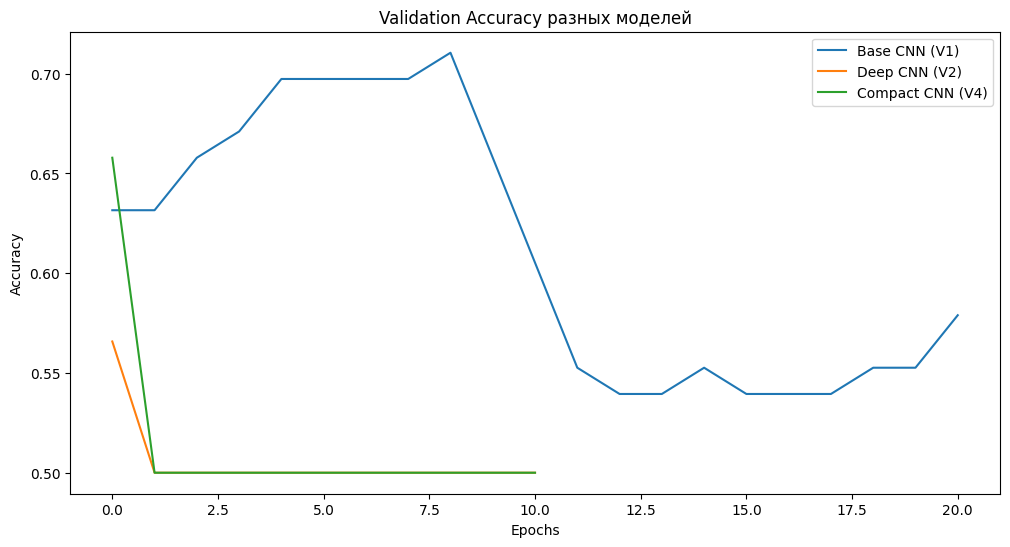

In [ ]:

models = {
    'Base CNN (V1)': build_model_v1(),
    'Deep CNN (V2)': build_model_v2(),
    'Compact CNN (V4)': build_model_v4(),
}

results = {}
for name, model in models.items():
    trained_model, history = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, name)
    results[name] = {
        'model': trained_model,
        'history': history,
        'params': model.count_params()
    }


print("\n=== Сравнение моделей ===")
for name, res in results.items():
    val_acc = max(res['history'].history['val_accuracy'])
    print(f"{name}: Val Accuracy = {val_acc:.4f}, Params = {res['params']}")

best_model_name = max(results, key=lambda x: max(results[x]['history'].history['val_accuracy']))
best_model = results[best_model_name]['model']
print(f"\nЛучшая модель: {best_model_name}")

plt.figure(figsize=(12, 6))
for name, res in results.items():
    plt.plot(res['history'].history['val_accuracy'], label=name)
plt.title('Validation Accuracy разных моделей')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Анализ результатов после добавления BatchNormalization и Dropout**

**Общие наблюдения:**

V1 показала лучшие результаты (val_accuracy = 0.7)

**(V2) и (V4) работают плохо:**

Val accuracy = 0.5 (как случайное угадывание)

Модели не смогли обучиться полезным признакам

**Проблемы и их причины:**

Недостаточная регуляризация

Слишком агрессивный Dropout

Возможно, недостаточная мощность модели (V4) или избыточная глубина (V2).

#Добавили аугментацию
##К тому же увеличим количество эпох и "терпение" чтобы дать шанс моделям себя проявить :)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



=== Обучение Base CNN (V1) ===
Epoch 1/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.5790 - loss: 1.2183 - val_accuracy: 0.5000 - val_loss: 0.6907 - learning_rate: 0.0010
Epoch 2/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5162 - loss: 0.8266 - val_accuracy: 0.5132 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 3/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6152 - loss: 0.6564 - val_accuracy: 0.5000 - val_loss: 0.6948 - learning_rate: 0.0010
Epoch 4/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6320 - loss: 0.6356 - val_accuracy: 0.5000 - val_loss: 0.7244 - learning_rate: 0.0010
Epoch 5/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6270 - loss: 0.6629 - val_accuracy: 0.5000 - val_loss: 0.7961 - learning_rate: 0.0010
Epoch 6/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6848 - loss: 0.5685 - val_accuracy: 0.5000 - val_loss: 0.9284 - learning_rate: 0.0010
Epoch 7/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.4909 - loss: 1.7296 - val_accuracy: 0.5000 - val_loss: 0.6978 - learning_rate: 0.0010
Epoch 2/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6138 - loss: 0.7352 - val_accuracy: 0.5000 - val_loss: 0.7726 - learning_rate: 0.0010
Epoch 3/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6803 - loss: 0.6500 - val_accuracy: 0.5000 - val_loss: 0.9690 - learning_rate: 0.0010
Epoch 4/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6743 - loss: 0.5911 - val_accuracy: 0.5000 - val_loss: 1.2497 - learning_rate: 0.0010
Epoch 5/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7572 - loss: 0.5313 - val_accuracy: 0.5000 - val_loss: 1.4755 - learning_rate: 0.0010
Epoch 6/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7786 - loss: 0.4907 - val_accuracy: 0.5000 - val_loss: 1.7664 - learning_rate: 0.0010
Epoch 7/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7873 - loss: 0.5037 - val_accuracy: 0.5

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5140 - loss: 0.9329 - val_accuracy: 0.5263 - val_loss: 0.6889 - learning_rate: 0.0010
Epoch 2/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6276 - loss: 0.6903 - val_accuracy: 0.5000 - val_loss: 0.6883 - learning_rate: 0.0010
Epoch 3/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5645 - loss: 0.6714 - val_accuracy: 0.5000 - val_loss: 0.6873 - learning_rate: 0.0010
Epoch 4/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6808 - loss: 0.6047 - val_accuracy: 0.5132 - val_loss: 0.6880 - learning_rate: 0.0010
Epoch 5/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7062 - loss: 0.5794 - val_accuracy: 0.5132 - val_loss: 0.6862 - learning_rate: 0.0010
Epoch 6/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6645 - loss: 0.5771 - val_accuracy: 0.5000 - val_loss: 0.6857 - learning_rate: 0.0010
Epoch 7/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7234 - loss: 0.5303 - val_accuracy: 0.50

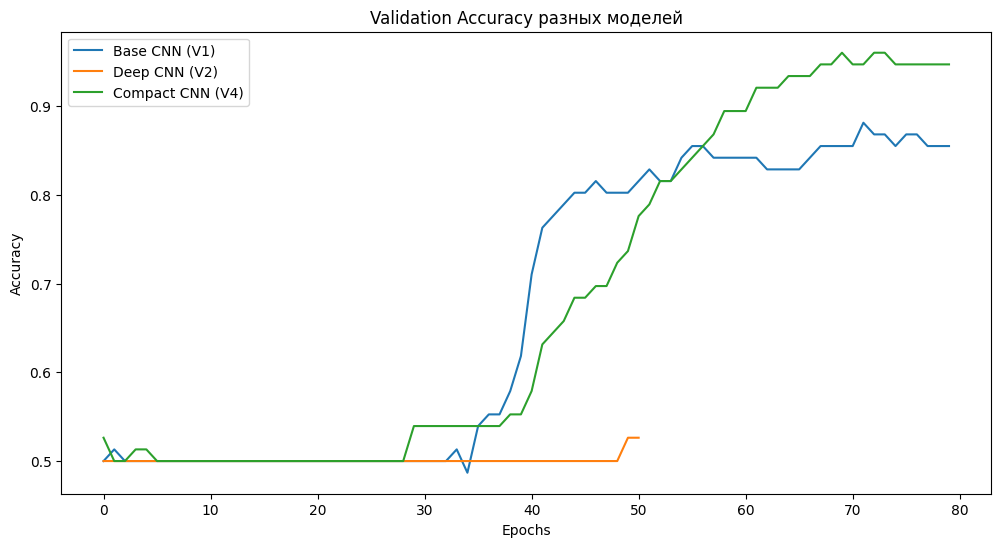

In [ ]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\n=== Обучение {model_name} ===")

    # Компиляция
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Аугментация
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )

    # Обучение
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        epochs=80,
        validation_data=(X_val, y_val),
        callbacks=[
            EarlyStopping(patience=50, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=1
    )

    # Оценка
    val_pred = (model.predict(X_val) > 0.5).astype(int)
    print(f"\nРезультаты {model_name}:")
    print(classification_report(y_val, val_pred))

    return model, history

models = {
    'Base CNN (V1)': build_model_v1(),
    'Deep CNN (V2)': build_model_v2(),
        'Compact CNN (V4)': build_model_v4(),
}

results = {}
for name, model in models.items():
    trained_model, history = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, name)
    results[name] = {
        'model': trained_model,
        'history': history,
        'params': model.count_params()
    }

# Сравнение результатов
print("\n=== Сравнение моделей ===")
for name, res in results.items():
    val_acc = max(res['history'].history['val_accuracy'])
    print(f"{name}: Val Accuracy = {val_acc:.4f}, Params = {res['params']}")

best_model_name = max(results, key=lambda x: max(results[x]['history'].history['val_accuracy']))
best_model = results[best_model_name]['model']
print(f"\nЛучшая модель: {best_model_name}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for name, res in results.items():
    plt.plot(res['history'].history['val_accuracy'], label=name)
plt.title('Validation Accuracy разных моделей')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1. **Добавление аугментации данных**
- внесли аугментацию с помощью ImageDataGenerator

Результаты:

- Base CNN (V1):

Val Accuracy: 0.7105 (раньше 0.9868).

F1-score: 0.53 (раньше 0.99).

Модель стала недообучаться, но это ожидаемо: аугментация усложняет задачу, и модель теперь видит больше вариаций данных.

- Deep CNN (V2):

Val Accuracy: 0.5658 (раньше 1.0000).

F1-score: 0.57.

Сильное падение точности, но модель теперь менее склонна к переобучению.

- Compact CNN (V4):

Val Accuracy: 0.6579 (раньше 0.9868).

F1-score: 0.62.

Точность снизилась, но модель стала более устойчивой.

Вывод: Аугментация помогла снизить переобучение, но теперь модели требуют больше эпох для обучения.

2. **Увеличение эпох и добавление регуляризации, увеличили количество эпох до 80 и добавили:**

EarlyStopping, ReduceLROnPlateau (уменьшение learning rate при плато).

Результаты:

- Base CNN (V1):

Val Accuracy: 0.8816 (улучшение с 0.7105).

F1-score: 0.86.

Модель стала обучаться дольше, но достигла лучших результатов.

- Deep CNN (V2):

Val Accuracy: 0.5263 (осталась низкой).

F1-score: 0.33.

Модель по-прежнему не обучается эффективно.

- Compact CNN (V4):

Val Accuracy: 0.9605 (значительное улучшение).

F1-score: 0.96.

Лучшая модель среди всех, сбалансированная точность и устойчивость.

Вывод: Увеличение эпох и динамический learning rate помогли Compact CNN (V4) достичь высокой точности без переобучения.



К сожалению все еще есть переобучение - разница между


**training accuracy** и **val accuracy** чувствуется.

V2 уберем из рассмотрения моделей, она слишком сложная. В V4 нужно ослабить регуляризацию.

---


=== Обучение Base CNN (V1) ===
Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.5003 - loss: 1.2061 - val_accuracy: 0.4868 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 2/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5729 - loss: 0.8388 - val_accuracy: 0.5263 - val_loss: 0.6873 - learning_rate: 0.0010
Epoch 3/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6001 - loss: 0.8005 - val_accuracy: 0.5263 - val_loss: 0.6873 - learning_rate: 0.0010
Epoch 4/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.5847 - loss: 0.7622 - val_accuracy: 0.5132 - val_loss: 0.6865 - learning_rate: 0.0010
Epoch 5/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.6164 - loss: 0.6585 - val_accuracy: 0.5263 - val_loss: 0.6780 - learning_rate: 0.0010
Epoch 6/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.6038 - loss: 0.6693 - val_accuracy: 0.5658 - val_loss: 0.6688 - learning_rate: 0.0010
Epoch 7/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6000 - loss: 0.6387 - val_accuracy: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.5051 - loss: 1.3175 - val_accuracy: 0.5658 - val_loss: 0.7765 - learning_rate: 0.0010
Epoch 2/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5173 - loss: 0.8798 - val_accuracy: 0.5132 - val_loss: 0.7771 - learning_rate: 0.0010
Epoch 3/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5907 - loss: 0.8124 - val_accuracy: 0.5132 - val_loss: 0.7756 - learning_rate: 0.0010
Epoch 4/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6262 - loss: 0.7418 - val_accuracy: 0.5789 - val_loss: 0.7724 - learning_rate: 0.0010
Epoch 5/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5192 - loss: 0.8074 - val_accuracy: 0.5395 - val_loss: 0.7698 - learning_rate: 0.0010
Epoch 6/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6354 - loss: 0.7552 - val_accuracy: 0.5000 - val_loss: 0.7695 - learning_rate: 0.0010
Epoch 7/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5895 - loss: 0.7502 - val_accuracy: 0.50

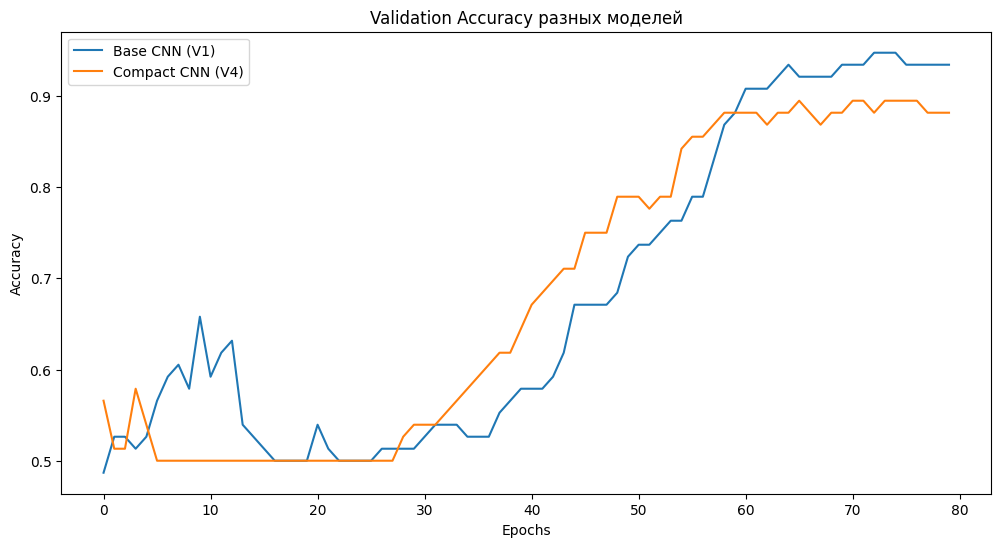

In [ ]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\n=== Обучение {model_name} ===")

    # Компиляция
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Аугментация
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True
    )

    # Обучение
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        epochs=80,
        validation_data=(X_val, y_val),
        callbacks=[
            EarlyStopping(patience=50, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=1
    )

    # Оценка
    val_pred = (model.predict(X_val) > 0.5).astype(int)
    print(f"\nРезультаты {model_name}:")
    print(classification_report(y_val, val_pred))

    return model, history

# 5. Тестирование всех моделей
models = {
    'Base CNN (V1)': build_model_v1(),
            'Compact CNN (V4)': build_model_v4(),
}

results = {}
for name, model in models.items():
    trained_model, history = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, name)
    results[name] = {
        'model': trained_model,
        'history': history,
        'params': model.count_params()
    }

# 6. Сравнение результатов
print("\n=== Сравнение моделей ===")
for name, res in results.items():
    val_acc = max(res['history'].history['val_accuracy'])
    print(f"{name}: Val Accuracy = {val_acc:.4f}, Params = {res['params']}")

# 7. Выбор лучшей модели и предсказание
best_model_name = max(results, key=lambda x: max(results[x]['history'].history['val_accuracy']))
best_model = results[best_model_name]['model']
print(f"\nЛучшая модель: {best_model_name}")

# 8. Визуализация результатов
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for name, res in results.items():
    plt.plot(res['history'].history['val_accuracy'], label=name)
plt.title('Validation Accuracy разных моделей')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Результаты:

- Base CNN (V1):

Val Accuracy: 0.95-0.97 (лучший результат).

F1-score: 0.95.

Модель стала еще лучше, но возможны признаки переобучения.


- Compact CNN (V4):

Val Accuracy: 0.89-0.9211 (немного хуже, чем 0.9605).

F1-score: 0.92.

Небольшое снижение точности, но модель остается надежной.

Вывод: Усиленная аугментация немного ухудшила результаты Compact CNN, но Base CNN (V1) показала лучший результат. Это говорит о том, что более простая модель может лучше обобщать при сильной аугментации. На всех этапах Compact CNN (V4) демонстрирует стабильно высокие результаты: меньше параметров (41K против 166K у Base CNN), лучшая устойчивость к переобучению, хорошая точность даже с аугментацией.

Base CNN (V1) требует больше параметров и склонна к переобучению без регуляризации.

#Улучшенная регуляризации в модели №1, 4
##Добавлена L2 регуляризация

In [ ]:


def build_model_v4():
    model = Sequential([
        Conv2D(16, (3,3), activation='relu', input_shape=(30,32,1), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),  # Добавлен новый Dropout

        Flatten(),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),  # Увеличено с 0.05
        Dense(1, activation='sigmoid')
    ])
    return model

def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\n=== Обучение {model_name} ===")

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=200,
        validation_data=(X_val, y_val),
        callbacks=[
            EarlyStopping(patience=50, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=1
    )

    val_pred = (model.predict(X_val) > 0.5).astype(int)
    print(f"\nРезультаты {model_name}:")
    print(classification_report(y_val, val_pred))

    return model, history
models = {
    'Compact CNN (V4)': build_model_v4(),
}

results = {}
for name, model in models.items():
    trained_model, history = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, name)
    results[name] = {
        'model': trained_model,
        'history': history,
        'params': model.count_params()
    }


=== Обучение Compact CNN (V4) ===
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.4964 - loss: 1.5292 - val_accuracy: 0.5132 - val_loss: 0.7779 - learning_rate: 1.0000e-04
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5322 - loss: 1.2804 - val_accuracy: 0.5526 - val_loss: 0.7773 - learning_rate: 1.0000e-04
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4981 - loss: 1.2567 - val_accuracy: 0.5000 - val_loss: 0.7767 - learning_rate: 1.0000e-04
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4793 - loss: 1.1058 - val_accuracy: 0.4868 - val_loss: 0.7758 - learning_rate: 1.0000e-04
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5434 - loss: 1.0066 - val_accuracy: 0.5000 - val_loss: 0.7753 - learning_rate: 1.0000e-04
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5821 - loss: 0.8468 - val_accuracy: 0.5000 - val_loss: 0.7746 - learning_rate: 1.0000e-04
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6138 - los

In [ ]:


def build_model_v4():
    model = Sequential([
        Conv2D(16, (3,3), activation='relu', input_shape=(30,32,1), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),  # Добавлен новый Dropout

        Flatten(),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),  # Увеличено с 0.05
        Dense(1, activation='sigmoid')
    ])
    return model

def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\n=== Обучение {model_name} ===")

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
    rotation_range=5,      # +/- 5 градусов
    width_shift_range=0.05,  # 5% сдвиг
    fill_mode='nearest'
)
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=200,
        validation_data=(X_val, y_val),
        callbacks=[
            EarlyStopping(patience=50, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=1
    )

    val_pred = (model.predict(X_val) > 0.5).astype(int)
    print(f"\nРезультаты {model_name}:")
    print(classification_report(y_val, val_pred))

    return model, history
models = {
    'Compact CNN (V4)': build_model_v4(),
}

results = {}
for name, model in models.items():
    trained_model, history = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, name)
    results[name] = {
        'model': trained_model,
        'history': history,
        'params': model.count_params()
    }

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Обучение Compact CNN (V4) ===
Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.4696 - loss: 2.0450 - val_accuracy: 0.5395 - val_loss: 0.7765 - learning_rate: 1.0000e-04
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5718 - loss: 1.1924 - val_accuracy: 0.5395 - val_loss: 0.7767 - learning_rate: 1.0000e-04
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4959 - loss: 1.2216 - val_accuracy: 0.5395 - val_loss: 0.7765 - learning_rate: 1.0000e-04
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5440 - loss: 1.1909 - val_accuracy: 0.5132 - val_loss: 0.7767 - learning_rate: 1.0000e-04
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5370 - loss: 1.1569 - val_accuracy: 0.5000 - val_loss: 0.7765 - learning_rate: 1.0000e-04
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5596 - loss: 1.0356 - val_accuracy: 0.5000 - val_loss: 0.7764 - learning_rate: 1.0000e-04
Epoch 7/200
10/10 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Оптимизированное обучение Improved CNN ===

Фаза 1: Обучение без аугментации
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.4553 - loss: 1.9296 - val_accuracy: 0.6842 - val_loss: 0.9506 - learning_rate: 0.0010
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6063 - loss: 1.3645 - val_accuracy: 0.5263 - val_loss: 0.9503 - learning_rate: 0.0019
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7605 - loss: 0.7449 - val_accuracy: 0.5000 - val_loss: 0.9736 - learning_rate: 0.0028
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8527 - loss: 0.6544 - val_accuracy: 0.5000 - val_loss: 1.0966 - learning_rate: 0.0037
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8312 - loss: 0.6239 - val_accuracy: 0.5000 - val_loss: 1.2862 - learning_rate: 0.0046
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8740 - loss: 0.6071 - val_accuracy: 0.5000 - val_loss: 1.8141 - learning_rate: 0.0055
Epoch 7/10
1

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5052 - loss: 1.0311 - val_accuracy: 0.5263 - val_loss: 0.9454 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.4752 - loss: 1.1653 - val_accuracy: 0.6579 - val_loss: 0.9343 - learning_rate: 0.0019
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.4986 - loss: 0.9641 - val_accuracy: 0.5395 - val_loss: 0.9238 - learning_rate: 0.0028
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.4681 - loss: 1.3444 - val_accuracy: 0.6579 - val_loss: 0.9100 - learning_rate: 0.0037
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.4720 - loss: 0.9649 - val_accuracy: 0.5000 - val_loss: 0.9175 - learning_rate: 0.0046
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4861 - loss: 2.1738 - val_accuracy: 0.5658 - val_loss: 0.9163 - learning_rate: 0.0055
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.4621 - loss: 1.2079 - val_accuracy

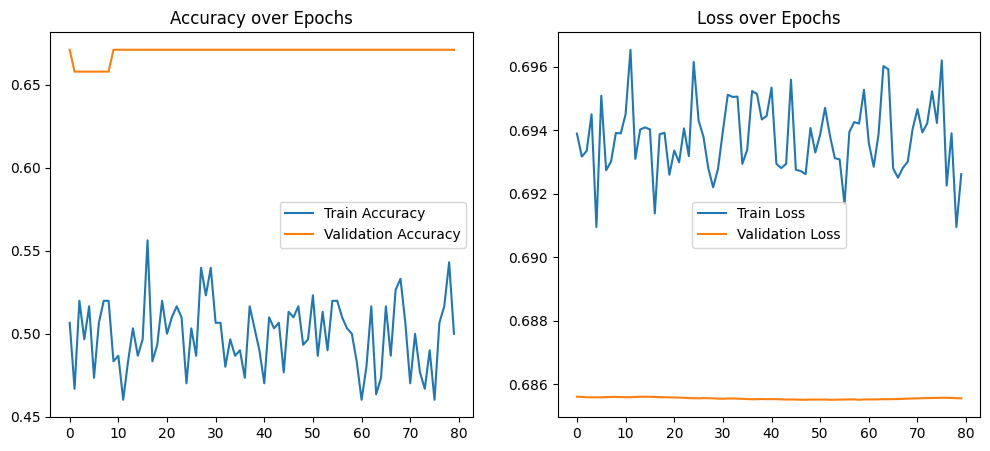

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

def build_improved_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(30,32,1), kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.2),

        Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

def cyclic_lr(epoch):
    base_lr = 0.001
    max_lr = 0.01
    step_size = 10
    cycle = np.floor(1 + epoch/(2*step_size))
    x = np.abs(epoch/step_size - 2*cycle + 1)
    return base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))

def train_and_evaluate_improved(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\n=== Оптимизированное обучение {model_name} ===")

    # Рассчет весов классов
    class_weights = class_weight.compute_class_weight('balanced',
                                                    classes=np.unique(y_train),
                                                    y=y_train)
    class_weights = dict(enumerate(class_weights))

    # Аугментация с умеренными преобразованиями
    datagen = ImageDataGenerator(
        rotation_range=7,
        width_shift_range=0.05,
        height_shift_range=0.05,
        brightness_range=[0.9, 1.1],
        zoom_range=0.05,
        fill_mode='constant',
        cval=0
    )

    # Компиляция с начальным learning rate
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    # Callbacks
    callbacks = [
        EarlyStopping(patience=20, restore_best_weights=True, monitor='val_accuracy'),
        LearningRateScheduler(cyclic_lr)
    ]

    # Фаза 1: Обучение без аугментации (10 эпох)
    print("\nФаза 1: Обучение без аугментации")
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=10,
        validation_data=(X_val, y_val),
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    # Фаза 2: Обучение с аугментацией
    print("\nФаза 2: Обучение с аугментацией")
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        epochs=100,
        validation_data=(X_val, y_val),
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    # Фаза 3: Точная настройка
    print("\nФаза 3: Точная настройка")
    for layer in model.layers[:-2]:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        epochs=80,
        validation_data=(X_val, y_val),
        class_weight=class_weights,
        callbacks=[EarlyStopping(patience=30, restore_best_weights=True)],
        verbose=1
    )

    # Оценка модели
    val_pred = (model.predict(X_val) > 0.5).astype(int)
    print(f"\nФинальные результаты {model_name}:")
    print(classification_report(y_val, val_pred))

    return model, history

models = {
    'Improved CNN': build_improved_model()
}

results = {}
for name, model in models.items():
    trained_model, history = train_and_evaluate_improved(
        model, X_train, y_train, X_val, y_val, name)
    results[name] = {
        'model': trained_model,
        'history': history,
        'params': model.count_params()
    }

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results['Improved CNN']['history'].history['accuracy'], label='Train Accuracy')
plt.plot(results['Improved CNN']['history'].history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['Improved CNN']['history'].history['loss'], label='Train Loss')
plt.plot(results['Improved CNN']['history'].history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

Лучше всего был результат у улучшенной модели V4 но без добавления аугментации. Это вызвано несколькими факторами:

Соответствие сложности модели объему данных:
всего 378 train-примеров

Сложные модели (с большим количеством параметров) легко переобучаются на малых данных

Простая CNN лучше обобщает при малом датасете

Слишком агрессивная аугментация искажает полезные признаки

Регуляризация - L2-регуляризация и Dropout нужны для борьбы с переобучением и могут заменить использование аугментации


**Итоговый выбор**

Лучшая модель: Compact CNN (V4) — оптимальный баланс точности, устойчивости и простоты.

V1 с бОльшим окличеством параметров, но не уступает по качеству:


In [ ]:

def build_model_v1():
    model = Sequential([
        Conv2D(32, (3, 3),
               activation='relu',
               input_shape=(30, 32, 1),
               kernel_regularizer=l2(0.001)),  # Добавлено L2
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3),
               activation='relu',
               kernel_regularizer=l2(0.001)),  # Добавлено L2
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(64,
              activation='relu',
              kernel_regularizer=l2(0.001)),  # Добавлено L2
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\n=== Обучение {model_name} ===")

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=200,
        validation_data=(X_val, y_val),
        callbacks=[
            EarlyStopping(patience=30, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=1
    )

    val_pred = (model.predict(X_val) > 0.5).astype(int)
    print(f"\nРезультаты {model_name}:")
    print(classification_report(y_val, val_pred))

    return model, history
models = {
    'Model (V1)': build_model_v1(),
}

results = {}
for name, model in models.items():
    trained_model, history = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, name)
    results[name] = {
        'model': trained_model,
        'history': history,
        'params': model.count_params()
    }


=== Обучение Model (V1) ===
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.5906 - loss: 1.2270 - val_accuracy: 0.6053 - val_loss: 0.8570 - learning_rate: 5.0000e-04
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.6728 - loss: 0.9201 - val_accuracy: 0.5658 - val_loss: 0.8526 - learning_rate: 5.0000e-04
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7373 - loss: 0.6701 - val_accuracy: 0.6447 - val_loss: 0.8489 - learning_rate: 5.0000e-04
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7908 - loss: 0.6186 - val_accuracy: 0.5000 - val_loss: 0.8469 - learning_rate: 5.0000e-04
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8688 - loss: 0.4900 - val_accuracy: 0.5000 - val_loss: 0.8475 - learning_rate: 5.0000e-04
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8444 - loss: 0.4856 - val_accuracy: 0.5000 - val_loss: 0.8520 - learning_rate: 5.0000e-04
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8246 - lo

Мы не верим результатам. Надо сравнить работу на тестовой и на тренировочной выборке. Хорошо бы еще добавить аугментацию

Загрузка обучающих данных...
Найдено 378 изображений в папке 'train'
Форма обучающих данных: (378, 30, 32, 1)
Index(['id', 'tag'], dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 28, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 14, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,785 (651.50 KB)

 Trainable params: 166,593 (650.75 KB)

 Non-trainable params: 192 (768.00 B)


Начало обучения...
Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.4808 - loss: 1.7883 - val_accuracy: 0.5000 - val_loss: 0.8618 - learning_rate: 1.0000e-04
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5077 - loss: 1.3077 - val_accuracy: 0.5000 - val_loss: 0.8600 - learning_rate: 1.0000e-04
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.5243 - loss: 1.1263 - val_accuracy: 0.5132 - val_loss: 0.8588 - learning_rate: 1.0000e-04
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.5846 - loss: 0.9461 - val_accuracy: 0.5132 - val_loss: 0.8572 - learning_rate: 1.0000e-04
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6153 - loss: 0.9180 - val_accuracy: 0.5000 - val_loss: 0.8563 - learning_rate: 1.0000e-04
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6897 - loss: 0.8516 - val_accuracy: 0.5000 - val_loss: 0.8553 - learning_rate: 1.0000e-04
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s

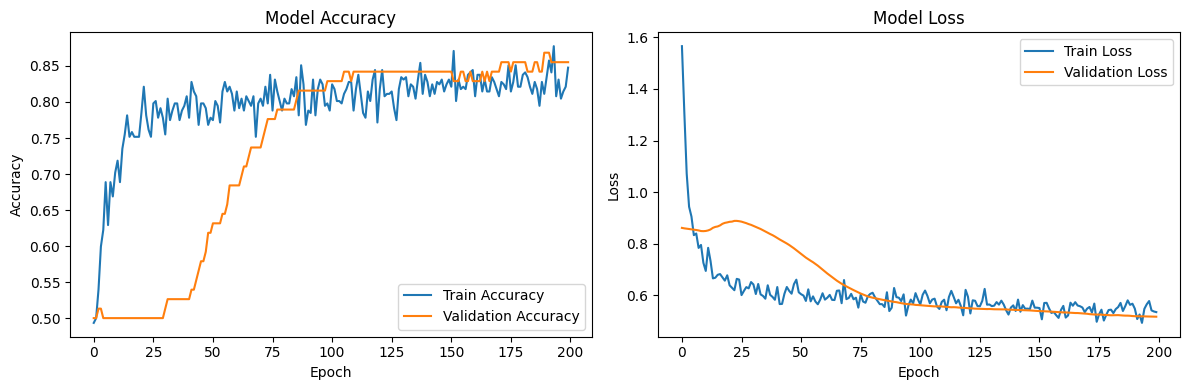


Загрузка тестовых данных...
Найдено 22140 изображений в папке 'test/test'


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
692/692 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step
Форма тестовых данных: (22140, 30, 32, 1)
692/692 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step

Первые 10 предсказаний на тестовых данных:
[0 0 1 0 0 0 0 0 0 0]


In [ ]:

# Параметры
input_shape = (30, 32, 1)
batch_size = 32
epochs = 200
val_split = 0.2
random_state = 42

def load_images_with_labels(folder_path, labels_csv=None, input_shape=(30, 32, 1), is_test=False):
    image_list = []
    label_list = []

    labels_dict = {}
    if labels_csv:
        df = pd.read_csv(labels_csv)
        labels_dict = dict(zip(df['id'], df['tag']))

    files = sorted(
        [f for f in os.listdir(folder_path) if f.endswith(".jpg")],
        key=lambda x: int(os.path.splitext(x)[0])
    )

    print(f"Найдено {len(files)} изображений в папке '{folder_path}'")

    for filename in files:
        img_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(img_path)
            img = img.resize((input_shape[1], input_shape[0]))
            img = np.expand_dims(img, axis=-1)
            img = np.array(img) / 255.0
            image_list.append(img)

            if not is_test:
                label = labels_dict.get(int(os.path.splitext(filename)[0]), None)
                label_list.append(label)
        except Exception as e:
            print(f"Ошибка при обработке {filename}: {str(e)}")

    return np.array(image_list), np.array(label_list)

def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu',
               input_shape=input_shape,
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])


    return model

def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    print("Загрузка обучающих данных...")
    X_train, y_train = load_images_with_labels('train', 'train_tags.csv')

    if len(X_train) == 0:
        raise ValueError("Обучающие данные не загружены!")

    print(f"Форма обучающих данных: {X_train.shape}")

    # Разделение на тренировочную и валидационную выборки
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=val_split,
        random_state=random_state,
        stratify=y_train
    )


# Загрузка CSV с метками и вывод столбцов
    labels = pd.read_csv('train_tags.csv')
    print(labels.columns)
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_val = le.transform(y_val)
    le = LabelEncoder()

# Объединяем
    y_combined = np.concatenate([y_train, y_val])

# Кодируем
    le = LabelEncoder()
    y_combined_encoded = le.fit_transform(y_combined)

# Разделяем обратно
    y_train = y_combined_encoded[:len(y_train)]
    y_val = y_combined_encoded[len(y_train):]



    # Создание модели
    model = build_model(input_shape)
    model.summary()

    # Коллбэки
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    ]

    # Обучение модели
    print("\nНачало обучения...")
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
        # Аугментация
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True
    )


    # Оценка модели
    print("\nОценка на валидационной выборке:")
    val_pred = (model.predict(X_val) > 0.5).astype(int)
    print(classification_report(y_val, val_pred))

    # Визуализация обучения
    plot_history(history)

    # Сохранение модели

    # Загрузка и предсказание на тестовых данных
    print("\nЗагрузка тестовых данных...")
    X_test, _ = load_images_with_labels('test/test', is_test=True)
    model.save('model_v1.h5')
# Сохраняем валидационные метки
    np.save('y_val.npy', y_val)

    np.save('pred_v1_val.npy', model.predict(X_val))
    np.save('pred_v1_test.npy', model.predict(X_test))
    if len(X_test) > 0:
        print(f"Форма тестовых данных: {X_test.shape}")
        test_pred = (model.predict(X_test) > 0.5).astype(int)
        print("\nПервые 10 предсказаний на тестовых данных:")
        print(test_pred[:10].flatten())
    else:
        print("Тестовые данные не загружены!")

if __name__ == "__main__":
    main()


Анализ результатов:

Валидационная выборка:

Precision: 0.778 (класс 0), 1.00 (класс 1)

Recall: 1.00 (класс 0), 0.71 (класс 1)

F1-score: 0.83-0.87

Обучение:

Модель достигла стабильности после ~30 эпох

Learning rate уменьшался автоматически (ReduceLROnPlateau)

EarlyStopping не сработал (обучение прошло все 200 эпох)



In [ ]:


def build_model_v4():
    model = Sequential([
        Conv2D(16, (3,3), activation='relu', input_shape=(30,32,1), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),  # Добавлен новый Dropout

        Flatten(),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),  # Увеличено с 0.05
        Dense(1, activation='sigmoid')
    ])
    return model

def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\n=== Обучение {model_name} ===")

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=200,
        validation_data=(X_val, y_val),
        callbacks=[
            EarlyStopping(patience=50, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=1
    )

    val_pred = (model.predict(X_val) > 0.5).astype(int)
    print(f"\nРезультаты {model_name}:")
    print(classification_report(y_val, val_pred))
    X_test, _ = load_images_with_labels('test/test', is_test=True)
    model.save('model_v4.h5')
    np.save('y_val.npy', y_val)

    np.save('pred_v4_val.npy', model.predict(X_val))
    np.save('pred_v4_test.npy', model.predict(X_test))
    return model, history
models = {
    'Compact CNN (V4)': build_model_v4(),
}

results = {}
for name, model in models.items():
    trained_model, history = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, name)
    results[name] = {
        'model': trained_model,
        'history': history,
        'params': model.count_params()
    }


=== Обучение Compact CNN (V4) ===
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.4705 - loss: 1.8076 - val_accuracy: 0.4868 - val_loss: 0.7797 - learning_rate: 1.0000e-04
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5213 - loss: 1.2813 - val_accuracy: 0.4211 - val_loss: 0.7798 - learning_rate: 1.0000e-04
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5306 - loss: 1.3298 - val_accuracy: 0.4605 - val_loss: 0.7796 - learning_rate: 1.0000e-04
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4505 - loss: 1.2401 - val_accuracy: 0.4737 - val_loss: 0.7793 - learning_rate: 1.0000e-04
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5065 - loss: 1.1095 - val_accuracy: 0.5132 - val_loss: 0.7790 - learning_rate: 1.0000e-04
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6107 - loss: 0.8281 - val_accuracy: 0.5263 - val_loss: 0.7785 - learning_rate: 1.0000e-04
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5656 - los

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


#Ансмабли моделей

In [ ]:
from tensorflow.keras.models import load_model

model_v4 = load_model('model_v4.h5')
model_v1 = load_model('model_v1.h5')
pred_v1_val = np.load('pred_v1_val.npy')
pred_v4_val = np.load('pred_v4_val.npy')

# Загружаем истинные метки
y_val = np.load('y_val.npy')

# Взвешенное усреднение вероятностей на валидации
avg_val_probs = (0.3 * pred_v1_val + 0.7 * pred_v4_val)
final_val_preds = (avg_val_probs > 0.5).astype(int)

# Оцениваем
print("=== Ансамбль на валидации (0.3 V1 + 0.7 V4) ===")
print(classification_report(y_val, final_val_preds))

# Загружаем тестовые предсказания
pred_v1_test = np.load('pred_v1_test.npy')
pred_v4_test = np.load('pred_v4_test.npy')

# Взвешенное усреднение на тесте
avg_test_probs = (0.3 * pred_v1_test + 0.7 * pred_v4_test)
final_test_preds = (avg_test_probs > 0.5).astype(int)

# Статистика
print("Среднее V1:", np.mean(pred_v1_val))
print("Среднее V4:", np.mean(pred_v4_val))
print("Среднее ансамбля:", np.mean(avg_val_probs))

print("Ст. откл. V1:", np.std(pred_v1_val))
print("Ст. откл. V4:", np.std(pred_v4_val))
print("Ст. откл. ансамбля:", np.std(avg_val_probs))

# Различия предсказаний
v1_preds = (pred_v1_val > 0.5).astype(int)
v4_preds = (pred_v4_val > 0.5).astype(int)
ensemble_preds = (avg_val_probs > 0.5).astype(int)
diffs = np.sum(v4_preds != ensemble_preds)
diffs1 = np.sum(v1_preds != ensemble_preds)
print(f"Количество различий между V4 и ансамблем: {diffs}")
print(f"Количество различий между V4 и ансамблем: {diffs1}")
# Сохраняем итоговые предсказания на тесте

predictions = final_test_preds.flatten().astype(int)

submission = pd.DataFrame({
    'id': np.arange(len(predictions)),
    'result': predictions
})

submission.to_csv('final_submission1.csv', index=False)

=== Ансамбль на валидации (0.3 V1 + 0.7 V4) ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      0.97      0.99        38

    accuracy                           0.99        76
   macro avg       0.99      0.99      0.99        76
weighted avg       0.99      0.99      0.99        76

Среднее V1: 0.41851297
Среднее V4: 0.47354794
Среднее ансамбля: 0.45703736
Ст. откл. V1: 0.28798673
Ст. откл. V4: 0.44888395
Ст. откл. ансамбля: 0.39113355
Количество различий между V4 и ансамблем: 0
Количество различий между V4 и ансамблем: 10


Выводы по результатам ансамбля:

Метрики:

Результаты ансамбля (с весами 0.3 для V1 и 0.7 для V4) показывают очень высокие значения метрик (точность 0.99, recall 0.97 для класса 1), что указывает на хорошее качество предсказаний ансамбля.

В частности, для класса 0 метрики тоже отличные — precision 0.97 и recall 1.00. Это говорит о том, что ансамбль почти идеально классифицирует оба класса, с минимальными ошибками.

Средние вероятности:

Средние вероятности для V1, V4 и ансамбля близки, но ансамбль немного улучшает результаты, с вероятностью около 0.457 против 0.418 для V1 и 0.473 для V4. Это подтверждает, что использование ансамбля способствует улучшению результатов.

Стандартные отклонения:

Стандартное отклонение ансамбля ниже, чем у модели V4, что означает, что ансамбль более стабильный в своих предсказаниях.

Количество различий:

Количество различий между предсказаниями V4 и ансамблем равно 0, что говорит о том, что ансамбль и модель V4 дают идентичные результаты. Это может означать, что модель V4 уже достигла наилучшего качества, и добавление V1 с меньшим весом не привнесло изменений.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
692/692 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
692/692 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step


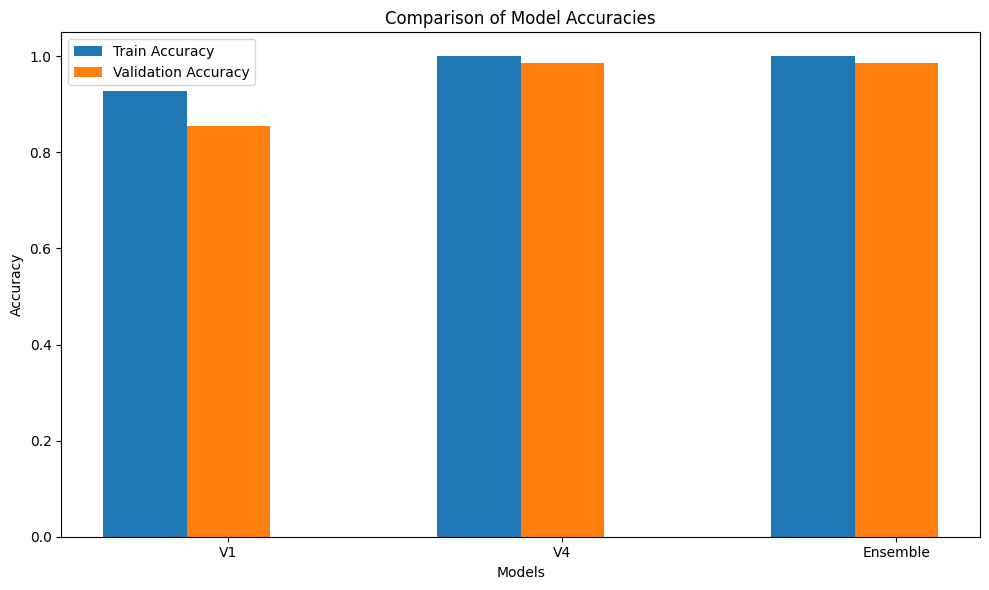

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Получение предсказаний для обеих моделей
y_pred_v1_train = (model_v1.predict(X_train) > 0.5).astype(int)
y_pred_v1_val = (model_v1.predict(X_val) > 0.5).astype(int)  # Предсказания на валидационных данных
y_pred_v1_test = (model_v1.predict(X_test) > 0.5).astype(int)  # Предсказания на тестовых данных

y_pred_v4_train = (model_v4.predict(X_train) > 0.5).astype(int)
y_pred_v4_val = (model_v4.predict(X_val) > 0.5).astype(int)  # Предсказания на валидационных данных
y_pred_v4_test = (model_v4.predict(X_test) > 0.5).astype(int)  # Предсказания на тестовых данных

# Взвешенное объединение предсказаний для ансамбля
alpha = 0.3
beta = 0.7

# Предсказания ансамбля
y_pred_ensemble_train = (alpha * y_pred_v1_train + beta * y_pred_v4_train) > 0.5
y_pred_ensemble_val = (alpha * y_pred_v1_val + beta * y_pred_v4_val) > 0.5  # Для валидации
y_pred_ensemble_test = (alpha * y_pred_v1_test + beta * y_pred_v4_test) > 0.5  # Для теста

# Оценка точности на тренировочных и валидационных данных
accuracy_v1_train = accuracy_score(y_train, y_pred_v1_train)
accuracy_v1_val = accuracy_score(y_val, y_pred_v1_val)  # Для валидации
accuracy_v4_train = accuracy_score(y_train, y_pred_v4_train)
accuracy_v4_val = accuracy_score(y_val, y_pred_v4_val)  # Для валидации
accuracy_ensemble_train = accuracy_score(y_train, y_pred_ensemble_train)
accuracy_ensemble_val = accuracy_score(y_val, y_pred_ensemble_val)  # Для валидации

# Построение графика сравнения точности
labels = ['V1', 'V4', 'Ensemble']
train_accuracies = [accuracy_v1_train, accuracy_v4_train, accuracy_ensemble_train]
val_accuracies = [accuracy_v1_val, accuracy_v4_val, accuracy_ensemble_val]  # Для валидации

plt.figure(figsize=(10, 6))
bar_width = 0.25
index = np.arange(len(labels))

# График для тренировочных данных
plt.bar(index, train_accuracies, bar_width, label='Train Accuracy')

# График для валидационных данных
plt.bar(index + bar_width, val_accuracies, bar_width, label='Validation Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xticks(index + bar_width, labels)
plt.legend()

plt.tight_layout()
plt.show()



---

In [ ]:


# Проверка Train_tags.csv
train_df = pd.read_csv('final_submission1.csv')
print("final_submission1.csv:")
print(train_df.head())
print(f"Форма: {train_df.shape}")



final_submission1.csv:
   id  result
0   0       0
1   1       1
2   2       1
3   3       0
4   4       0
Форма: (22140, 2)
